In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
import json
import nltk
from pyecharts.charts import Map, Bar 
from pyecharts import options as opts
from wordcloud import WordCloud, STOPWORDS

In [111]:
movie = pd.read_csv('./dataset/TMDB5000/tmdb_5000_movies.csv')
credit = pd.read_csv('./dataset/TMDB5000/tmdb_5000_credits.csv')
print('Movie: ', movie.shape, 'Credit: ', credit.shape)

Movie:  (4803, 20) Credit:  (4803, 4)


In [112]:
print((movie['id']==credit['movie_id']).describe())
print()
print((movie['title']==credit['title']).describe())

count     4803
unique       1
top       True
freq      4803
dtype: object

count     4803
unique       1
top       True
freq      4803
Name: title, dtype: object


## Data clean & Features extraction

merge dataset, Delete unnecessary information and delete duplication

In [113]:
del credit['movie_id']
del credit['title']

del movie['homepage']
del movie['original_title']
del movie['overview']
del movie['tagline']

new_df = pd.concat([movie,credit],axis=1)
new_df.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 2
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
cast                    0
crew                    0
dtype: int64


Missing value processing

In [114]:
nan = new_df['runtime'].isnull()
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Chiamatemi Francesco - Il Papa della gente,7.3,12,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,"To Be Frank, Sinatra at 100",0.0,0,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de..."


In [115]:
new_df.loc[2656,'runtime']='98'
new_df.loc[4140,'runtime']='82'
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,98,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Chiamatemi Francesco - Il Papa della gente,7.3,12,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,82,[],Released,"To Be Frank, Sinatra at 100",0.0,0,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de..."


In [116]:
nan = new_df['release_date'].isnull()
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
4553,0,[],380097,[],en,0.0,[],[],NaN,0,0.0,[],Released,America Is Still the Place,0.0,0,[],[]


In [117]:
new_df.loc[4553,'release_date']= '2022-06-10'
new_df.loc[nan,:]

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew
4553,0,[],380097,[],en,0.0,[],[],2022-06-10,0,0.0,[],Released,America Is Still the Place,0.0,0,[],[]


Type Conversion

In [118]:
new_df.loc[:,'release_date'] = pd.to_datetime(new_df.loc[:,'release_date'],format='%Y-%m-%d',errors='coerce')

In [119]:
new_df['release_year']=new_df['release_date'].dt.year
new_df['release_month']=new_df['release_date'].dt.month

In [120]:
json_cols = ['genres','keywords','production_companies','spoken_languages','production_countries','cast','crew']

for i in json_cols:
    new_df[i]=new_df[i].apply(json.loads) 

In [121]:
def get_names(x):
    return ','.join(i['name'] for i in x)

In [122]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']

In [123]:
for i in json_cols[:-1]:
    new_df[i]=new_df[i].apply(get_names)


In [124]:
new_df['crew'] = new_df['crew'].apply(get_director)
new_df.rename(columns={'crew':'director'},inplace=True)

In [125]:
new_df['production_countries'] = new_df['production_countries'].str.replace('United States of America','United States')

In [126]:
new_df['profit'] = new_df['revenue']-new_df['budget']

In [127]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                4803 non-null   int64         
 1   genres                4803 non-null   object        
 2   id                    4803 non-null   int64         
 3   keywords              4803 non-null   object        
 4   original_language     4803 non-null   object        
 5   popularity            4803 non-null   float64       
 6   production_companies  4803 non-null   object        
 7   production_countries  4803 non-null   object        
 8   release_date          4803 non-null   datetime64[ns]
 9   revenue               4803 non-null   int64         
 10  runtime               4803 non-null   object        
 11  spoken_languages      4803 non-null   object        
 12  status                4803 non-null   object        
 13  title             

Data filtering

In [128]:
new_df.describe()

,budget,id,popularity,revenue,vote_average,vote_count,release_year,release_month,profit
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4803.000000,4803.000000,4803.000000,4803.000000,4.803000e+03
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,6.092172,690.217989,2002.472829,6.795753,5.321560e+07
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,1.194612,1234.585891,12.416260,3.423850,1.359677e+08
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,1916.000000,1.000000,-1.657101e+08
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,5.600000,54.000000,1999.000000,4.000000,-7.995375e+05
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,6.200000,235.000000,2005.000000,7.000000,2.511317e+06
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,6.800000,737.000000,2011.000000,10.000000,5.531286e+07
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,10.000000,13752.000000,2022.000000,12.000000,2.550965e+09


In [129]:
new_df = new_df[(new_df.vote_count >= 50) &(new_df.budget * new_df.revenue * new_df.popularity * new_df.vote_average !=0)].reset_index(drop = 'True')

# df_budget = new_df[new_df['budget']!=0]
# budget_mean = df_budget['budget'].mean()
# new_df['budget'] = new_df['budget'].replace(0,budget_mean)

new_df


,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,...,spoken_languages,status,title,vote_average,vote_count,cast,director,release_year,release_month,profit
0,237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",en,150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States,United Kingdom",2009-12-10,2787965087,...,"English,Español",Released,Avatar,7.2,11800,"Sam Worthington,Zoe Saldana,Sigourney Weaver,S...",James Cameron,2009,12,2550965087
1,300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",en,139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States,2007-05-19,961000000,...,English,Released,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp,Orlando Bloom,Keira Knightley,Stel...",Gore Verbinski,2007,5,661000000
2,245000000,"Action,Adventure,Crime",206647,"spy,based on novel,secret agent,sequel,mi6,bri...",en,107.376788,"Columbia Pictures,Danjaq,B24","United Kingdom,United States",2015-10-26,880674609,...,"Français,English,Español,Italiano,Deutsch",Released,Spectre,6.3,4466,"Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...",Sam Mendes,2015,10,635674609
3,250000000,"Action,Crime,Drama,Thriller",49026,"dc comics,crime fighter,terrorist,secret ident...",en,112.312950,"Legendary Pictures,Warner Bros.,DC Entertainme...",United States,2012-07-16,1084939099,...,English,Released,The Dark Knight Rises,7.6,9106,"Christian Bale,Michael Caine,Gary Oldman,Anne ...",Christopher Nolan,2012,7,834939099
4,260000000,"Action,Adventure,Science Fiction",49529,"based on novel,mars,medallion,space travel,pri...",en,43.926995,Walt Disney Pictures,United States,2012-03-07,284139100,...,English,Released,John Carter,6.1,2124,"Taylor Kitsch,Lynn Collins,Samantha Morton,Wil...",Andrew Stanton,2012,3,24139100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,27000,Comedy,2292,"salesclerk,loser,aftercreditsstinger",en,19.748658,"Miramax Films,View Askew Productions",United States,1994-09-13,3151130,...,English,Released,Clerks,7.4,755,"Brian O'Halloran,Jeff Anderson,Jason Mewes,Kev...",Kevin Smith,1994,9,3124130
2957,12000,"Horror,Comedy,Crime",692,"gay,trailer park,pop culture,drug dealer,heroi...",en,4.553644,Dreamland Productions,United States,1972-03-12,6000000,...,English,Released,Pink Flamingos,6.2,110,"Divine,David Lochary,Mary Vivian Pearce,Mink S...",John Waters,1972,3,5988000
2958,20000,"Crime,Horror,Mystery,Thriller",36095,"japan,prostitute,hotel,based on novel,hallucin...",ja,0.212443,Daiei Studios,Japan,1997-11-06,99000,...,日本語,Released,Cure,7.4,63,"Koji Yakusho,Masato Hagiwara,Tsuyoshi Ujiki,An...",Kiyoshi Kurosawa,1997,11,79000
2959,7000,"Science Fiction,Drama,Thriller",14337,"distrust,garage,identity crisis,time travel,ti...",en,23.307949,Thinkfilm,United States,2004-10-08,424760,...,English,Released,Primer,6.9,658,"Shane Carruth,David Sullivan,Casey Gooden,Anan...",Shane Carruth,2004,10,417760


## Visualization

### Genres

In [130]:
genres_ = set()
for i in new_df['genres'].str.split(','):
    genres_ = set().union(i,genres_)
genres_=list(genres_)
# genres_.remove('')


In [131]:
for i in genres_:
    new_df[i]=new_df['genres'].str.contains(i).apply(lambda x : 1 if x else 0)
new_df.head(5)

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,...,Fantasy,Thriller,Family,History,Comedy,Animation,Science Fiction,Horror,Music,Action
0,237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",en,150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States,United Kingdom",2009-12-10,2787965087,...,1,0,0,0,0,0,1,0,0,1
1,300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",en,139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States,2007-05-19,961000000,...,1,0,0,0,0,0,0,0,0,1
2,245000000,"Action,Adventure,Crime",206647,"spy,based on novel,secret agent,sequel,mi6,bri...",en,107.376788,"Columbia Pictures,Danjaq,B24","United Kingdom,United States",2015-10-26,880674609,...,0,0,0,0,0,0,0,0,0,1
3,250000000,"Action,Crime,Drama,Thriller",49026,"dc comics,crime fighter,terrorist,secret ident...",en,112.312950,"Legendary Pictures,Warner Bros.,DC Entertainme...",United States,2012-07-16,1084939099,...,0,1,0,0,0,0,0,0,0,1
4,260000000,"Action,Adventure,Science Fiction",49529,"based on novel,mars,medallion,space travel,pri...",en,43.926995,Walt Disney Pictures,United States,2012-03-07,284139100,...,0,0,0,0,0,0,1,0,0,1


In [132]:
new_genres = new_df.groupby('release_year').sum()
new_genres.head(5)

,budget,id,popularity,revenue,vote_average,vote_count,release_month,profit,Crime,Western,...,Fantasy,Thriller,Family,History,Comedy,Animation,Science Fiction,Horror,Music,Action
release_year,,,,,,,,,,,,,,,,,,,,,
1916,385907,3059,3.232447,8394751,7.4,60,9,8008844,0,0,...,0,0,0,0,0,0,0,0,0,0
1927,92620000,19,32.351527,650422,8.0,657,1,-91969578,0,0,...,0,0,0,0,0,0,1,0,0,0
1934,325000,3078,11.871424,4500000,7.7,275,2,4175000,0,0,...,0,0,0,0,1,0,0,0,0,0
1935,609000,3080,3.898498,3202000,7.4,59,9,2593000,0,0,...,0,0,0,0,1,0,0,0,1,0
1936,1,3082,28.276480,8500000,8.1,856,2,8499999,0,0,...,0,0,0,0,1,0,0,0,0,0


The changes of movie genres during year

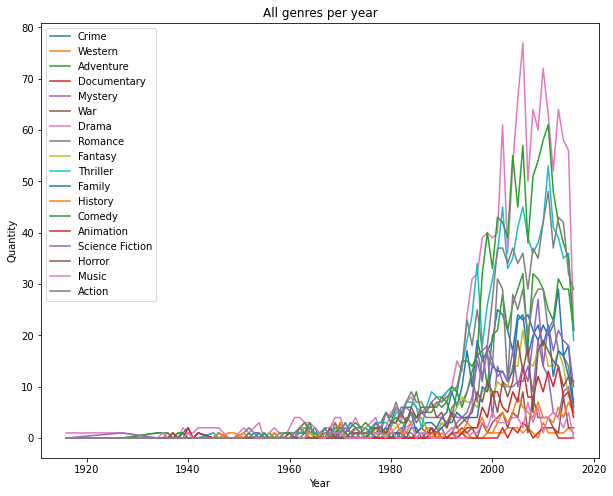

In [133]:
plt.figure(figsize=(10,8))
ax1=plt.subplot(1,1,1)
new_genres[genres_].plot(label='genres',kind='line',ax=ax1)
plt.title('All genres per year')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

Ranking of movies genres shooting quantity

In [134]:
genres = new_genres[genres_].sum(axis=0).sort_values(ascending=True)
genres

Documentary          20
Western              48
Music                92
War                 105
History             126
Animation           178
Mystery             256
Horror              325
Fantasy             329
Family              346
Science Fiction     412
Romance             500
Crime               502
Adventure           632
Action              866
Thriller            907
Comedy             1005
Drama              1288
dtype: int64

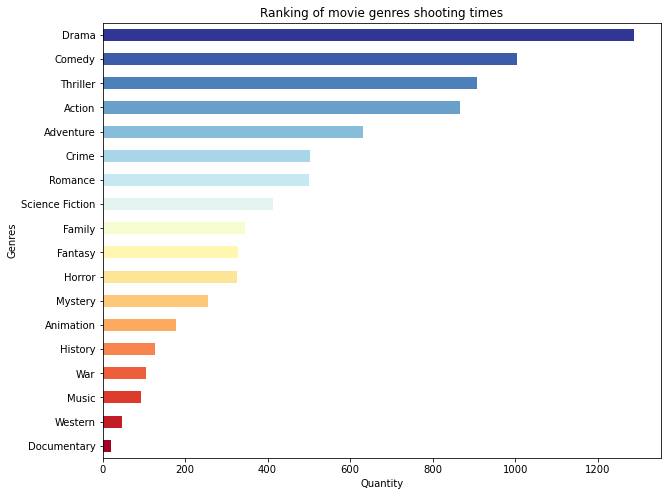

In [135]:
plt.figure(figsize=(10,8))
colors = cm.RdYlBu(np.linspace(0,1,len(genres)))
genres.plot(kind='barh',color=colors)
plt.title('Ranking of movie genres shooting times')
plt.xlabel('Quantity')
plt.ylabel('Genres')
plt.show()

Genres comparison (whether based on novel)
- original movie
- adapted movie

In [136]:
new_df['based on novel'] = new_df['keywords'].str.contains('based on novel').apply(lambda x :1 if x else 0)
new_df['not based on novel'] = new_df['keywords'].str.contains('based on novel').apply(lambda x : 0 if x else 1)
genres_based = new_df[['release_year','based on novel','not based on novel']]
genres_based.head(5)

,release_year,based on novel,not based on novel
0,2009,0,1
1,2007,0,1
2,2015,1,0
3,2012,0,1
4,2012,1,0


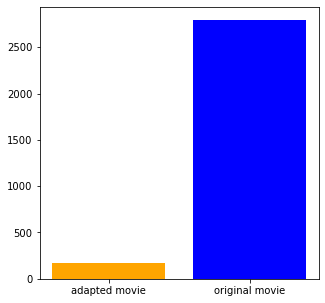

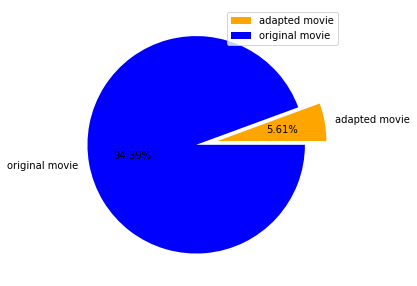

In [137]:
novel_list = [genres_based['based on novel'].sum(axis=0),genres_based['not based on novel'].sum(axis=0)]
plt.figure(0,figsize=(5,5))
plt.bar(['adapted movie', 'original movie'],novel_list,color=['orange','b'])

plt.figure(1,figsize=(5,5))
plt.pie(novel_list, labels = ['adapted movie', 'original movie'],colors=['orange','b'],autopct='%.2f%%',explode=[0.1,0.1])
plt.legend(loc='best')
plt.show()

(array([0, 1]),
 [Text(0, 0, '(original movies,)'), Text(1, 0, '(adapted movies,)')])

<Figure size 720x576 with 0 Axes>

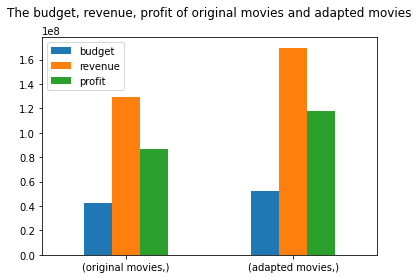

In [138]:
new_original=new_df[['not based on novel','based on novel','budget','revenue','profit']]
original_mean=new_original.groupby('based on novel').mean()
original_mean.index = [['original movies','adapted movies']]
original_mean.drop('not based on novel',axis=1, inplace=True)
plt.figure(figsize=(10,8))
original_mean.plot(kind='bar')
plt.title('The budget, revenue, profit of original movies and adapted movies\n')
plt.ylabel('')
plt.xticks(rotation=0)

Voting

In [139]:
genres_df = pd.DataFrame(index=range(0,4803),columns=genres_)
for i in pd.DataFrame(genres).index:
    list_=[]
    for j,t in zip(new_df["genres"],new_df["vote_average"]):
        if i in j:
            list_.append(t)
    genres_df[i]=pd.Series(list_)
genres_vote=genres_df.describe().T
genres_vote

,count,mean,std,min,25%,50%,75%,max
Crime,502.0,6.458765,0.757710,4.1,6.000,6.40,7.000,8.5
Western,48.0,6.785417,0.812401,4.4,6.300,7.00,7.400,8.1
Adventure,632.0,6.263924,0.843524,3.2,5.700,6.30,6.900,8.3
Documentary,20.0,6.840000,0.658067,4.8,6.575,6.85,7.300,7.7
Mystery,256.0,6.391016,0.756279,4.5,5.900,6.30,6.900,8.1
War,105.0,6.881905,0.778655,3.0,6.400,7.00,7.400,8.3
Drama,1288.0,6.664441,0.735698,3.5,6.200,6.70,7.200,8.5
Romance,500.0,6.418800,0.751729,4.3,5.900,6.50,7.000,8.2
Fantasy,329.0,6.193617,0.899859,3.1,5.600,6.20,6.800,8.3
Thriller,907.0,6.224146,0.797237,3.1,5.750,6.20,6.700,8.3


In [140]:
genres_df = genres_df.T.stack().reset_index(level=1
                            ,drop=True
                            ,inplace= False
                            ).reset_index().rename(columns={"index":"genres",0:"score"})
genres_df["genres"].value_counts().sort_index()

Action              866
Adventure           632
Animation           178
Comedy             1005
Crime               502
Documentary          20
Drama              1288
Family              346
Fantasy             329
History             126
Horror              325
Music                92
Mystery             256
Romance             500
Science Fiction     412
Thriller            907
War                 105
Western              48
Name: genres, dtype: int64

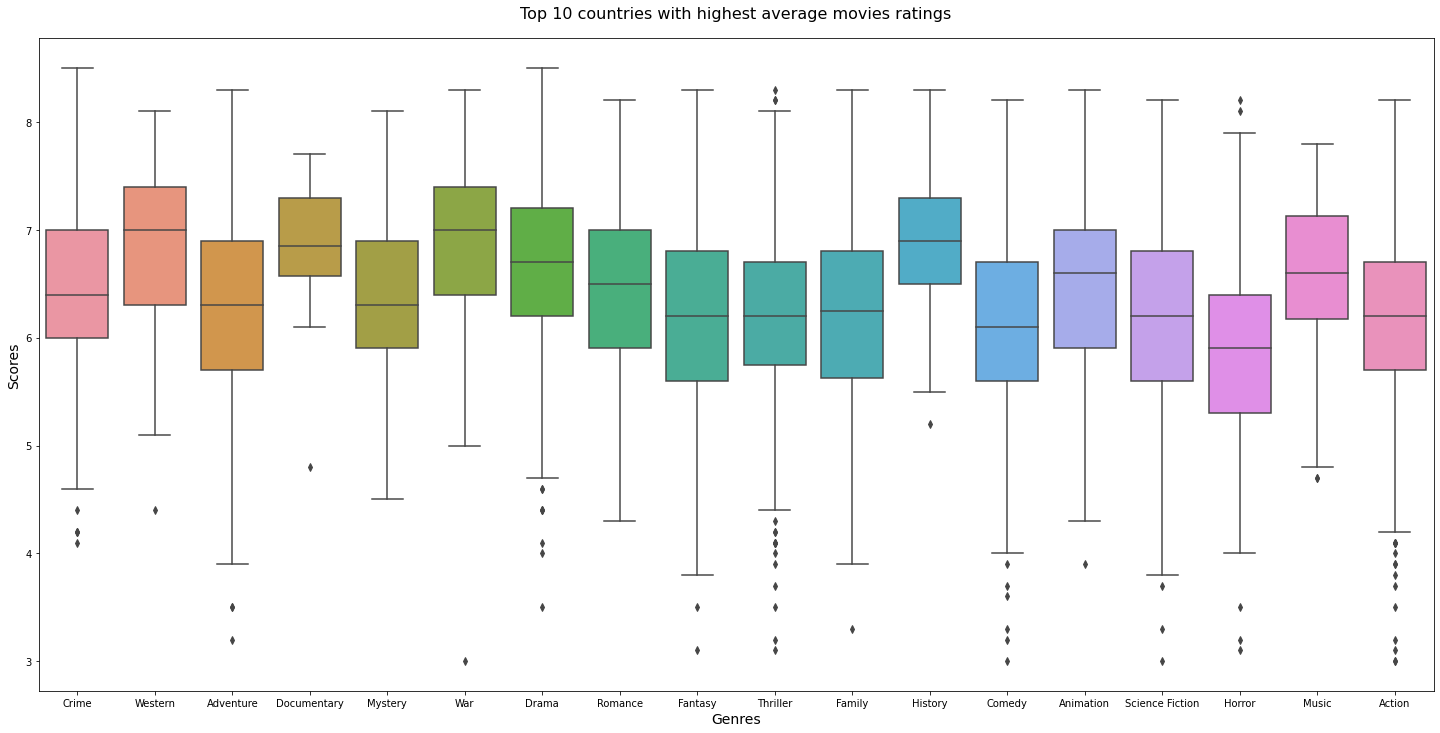

In [141]:
plt.figure(figsize=(25,12))
sns.boxplot(x='genres',y='score', data=genres_df)
plt.xlabel(xlabel="Genres",fontsize=14)
plt.ylabel(ylabel="Scores",fontsize=14)
plt.title('Top 10 countries with highest average movies ratings',fontsize=16,pad=20)
plt.show()

### Countries

In [142]:
index = 0
for i in new_df['production_countries']:
    if ',' in i:
        v = 'Cooperation' 
    else:
        v = i.split(',')[0]
    new_df.loc[index,'countries'] = v 
    index+=1

new_countries =pd.DataFrame()
new_countries['countries'] = new_df['countries'].value_counts().index
new_countries['num'] = new_df['countries'].value_counts().values
# new_countries.loc[new_countries['countries'] == 'United States of America','countries'] = 'United States'

countries_ = list(new_countries['countries'])

others = pd.DataFrame(data={
    'countries': ['others'],
    'num': [new_countries['num'][5:].sum()]
})

countries_plot = pd.concat([new_countries[:5],others])

Proportion of film production in different countries

(-1.1145363418251886, 1.309762861440394, -1.21010394916764, 1.1076129322203778)

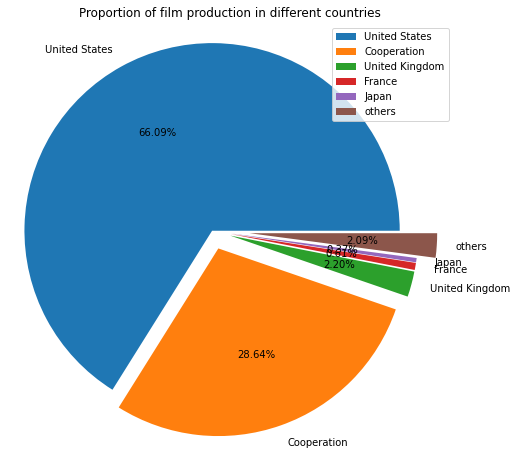

In [143]:
plt.figure(0,figsize=(8,8))
plt.pie(countries_plot['num'],labels=countries_plot['countries'],autopct='%.2f%%',explode=[0,0.1,0.1,0.1,0.1,0.2])
plt.legend()
plt.title('Proportion of film production in different countries')
plt.axis('equal')


In [144]:
for i in countries_:
    new_df[i]=new_df['production_countries'].str.contains(i).apply(lambda x : 1 if x else 0)
new_df.head(5)

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,...,South Africa,Hong Kong,New Zealand,Norway,Thailand,Fiji,Bulgaria,Russia,Brazil,Iran
0,237000000,"Action,Adventure,Fantasy,Science Fiction",19995,"culture clash,future,space war,space colony,so...",en,150.437577,"Ingenious Film Partners,Twentieth Century Fox ...","United States,United Kingdom",2009-12-10,2787965087,...,0,0,0,0,0,0,0,0,0,0
1,300000000,"Adventure,Fantasy,Action",285,"ocean,drug abuse,exotic island,east india trad...",en,139.082615,"Walt Disney Pictures,Jerry Bruckheimer Films,S...",United States,2007-05-19,961000000,...,0,0,0,0,0,0,0,0,0,0
2,245000000,"Action,Adventure,Crime",206647,"spy,based on novel,secret agent,sequel,mi6,bri...",en,107.376788,"Columbia Pictures,Danjaq,B24","United Kingdom,United States",2015-10-26,880674609,...,0,0,0,0,0,0,0,0,0,0
3,250000000,"Action,Crime,Drama,Thriller",49026,"dc comics,crime fighter,terrorist,secret ident...",en,112.312950,"Legendary Pictures,Warner Bros.,DC Entertainme...",United States,2012-07-16,1084939099,...,0,0,0,0,0,0,0,0,0,0
4,260000000,"Action,Adventure,Science Fiction",49529,"based on novel,mars,medallion,space travel,pri...",en,43.926995,Walt Disney Pictures,United States,2012-03-07,284139100,...,0,0,0,0,0,0,0,0,0,0


In [145]:
countries_year = pd.DataFrame()
countries_year = new_df.groupby('release_year').sum()
countries_year.head(5)

,budget,id,popularity,revenue,vote_average,vote_count,release_month,profit,Crime,Western,...,South Africa,Hong Kong,New Zealand,Norway,Thailand,Fiji,Bulgaria,Russia,Brazil,Iran
release_year,,,,,,,,,,,,,,,,,,,,,
1916,385907,3059,3.232447,8394751,7.4,60,9,8008844,0,0,...,0,0,0,0,0,0,0,0,0,0
1927,92620000,19,32.351527,650422,8.0,657,1,-91969578,0,0,...,0,0,0,0,0,0,0,0,0,0
1934,325000,3078,11.871424,4500000,7.7,275,2,4175000,0,0,...,0,0,0,0,0,0,0,0,0,0
1935,609000,3080,3.898498,3202000,7.4,59,9,2593000,0,0,...,0,0,0,0,0,0,0,0,0,0
1936,1,3082,28.276480,8500000,8.1,856,2,8499999,0,0,...,0,0,0,0,0,0,0,0,0,0


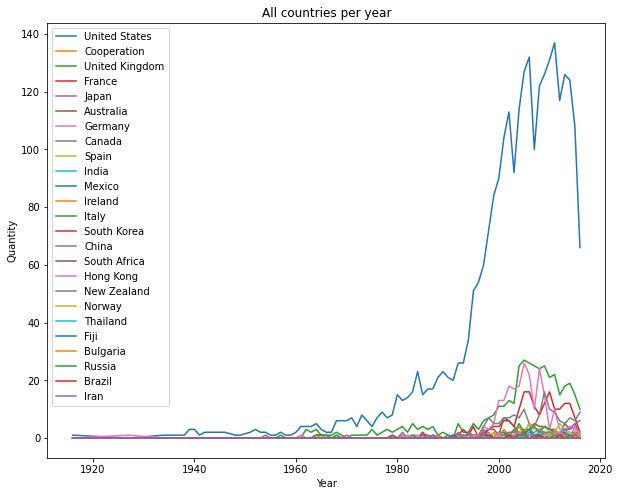

In [146]:
plt.figure(figsize=(10,8))
ax1=plt.subplot(1,1,1)
countries_year[countries_].plot(label='countries',kind='line',ax=ax1)
plt.title('All countries per year')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.show()

Voting

In [147]:
new_countries = new_countries.drop(index=new_countries[new_countries['countries']=='Cooperation'].index[0])

In [148]:
countries_vote=new_df.groupby("countries")["vote_average"].describe()
new_countries_vote=pd.DataFrame({"countries":countries_vote.index
                              ,"score":countries_vote["mean"]}).sort_values(by=["score"],ascending=False)

new_countries_vote


,countries,score
countries,,
Iran,Iran,7.800000
Brazil,Brazil,7.600000
Germany,Germany,7.571429
Mexico,Mexico,7.466667
Japan,Japan,7.345455
Italy,Italy,7.333333
India,India,7.320000
New Zealand,New Zealand,7.050000
China,China,6.933333


<Figure size 576x576 with 0 Axes>

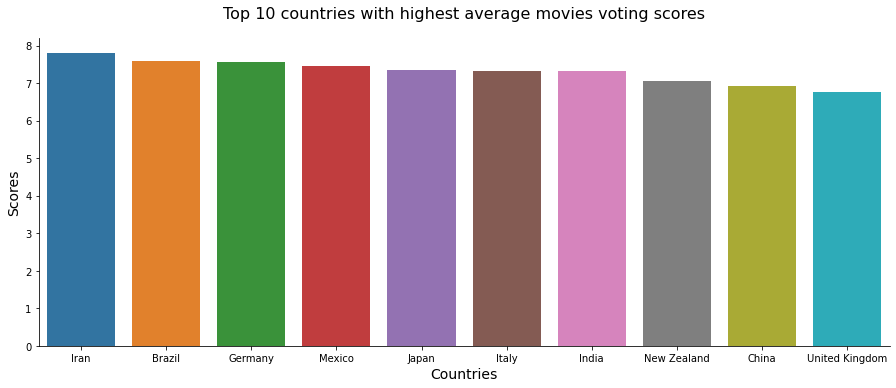

In [149]:
plt.figure(figsize=(8,8))
sns.catplot(x='countries',y='score', data=new_countries_vote[:10], kind='bar',aspect=2.5)
plt.xlabel(xlabel="Countries",fontsize=14)
plt.ylabel(ylabel="Scores",fontsize=14)
plt.title('Top 10 countries with highest average movies voting scores',fontsize=16,pad=20)
plt.show()

In [150]:
countries_df = pd.DataFrame(columns=countries_)
for i in new_countries['countries']:
    list_=[]
    for j,t in zip(new_df["production_countries"],new_df["vote_average"]):
        if i in j:
            list_.append(t)
    countries_df[i]=pd.Series(list_)
countries_vote = countries_df.describe().T
countries_vote

,count,mean,std,min,25%,50%,75%,max
United States,2691.0,6.318841,0.827541,3.0,5.800,6.30,6.900,8.5
United Kingdom,419.0,6.542482,0.786099,3.2,6.100,6.60,7.100,8.2
France,188.0,6.415957,0.734236,4.2,6.000,6.40,6.900,8.1
Japan,38.0,6.555263,1.033152,3.9,5.950,6.50,7.275,8.3
Australia,74.0,6.044595,0.805145,4.4,5.525,6.00,6.600,7.9
Germany,225.0,6.327556,0.885723,3.1,5.800,6.30,7.000,8.3
Canada,153.0,6.128758,0.837656,3.1,5.600,6.00,6.800,8.1
Spain,40.0,6.525000,0.810745,5.0,5.950,6.50,7.100,8.1
India,23.0,6.613043,1.071237,3.9,6.100,7.20,7.350,7.8
Mexico,14.0,6.757143,0.754182,5.4,6.075,6.95,7.300,7.6


In [151]:
countries_df = countries_df.T.stack().reset_index(level=1
                            ,drop=True
                            ,inplace= False
                            ).reset_index().rename(columns={"index":"countries",0:"score"})
countries_df["countries"].value_counts().sort_index()

Australia           74
Brazil               5
Bulgaria             3
Canada             153
China               34
Fiji                 1
France             188
Germany            225
Hong Kong           24
India               23
Iran                 1
Ireland             25
Italy               44
Japan               38
Mexico              14
New Zealand         21
Norway               6
Russia               6
South Africa         9
South Korea          5
Spain               40
Thailand             3
United Kingdom     419
United States     2691
Name: countries, dtype: int64

In [152]:
countries_df

,countries,score
0,United States,7.2
1,United States,6.9
2,United States,6.3
3,United States,7.6
4,United States,6.1
...,...,...
4047,Brazil,6.4
4048,Brazil,5.5
4049,Brazil,8.1
4050,Brazil,7.6


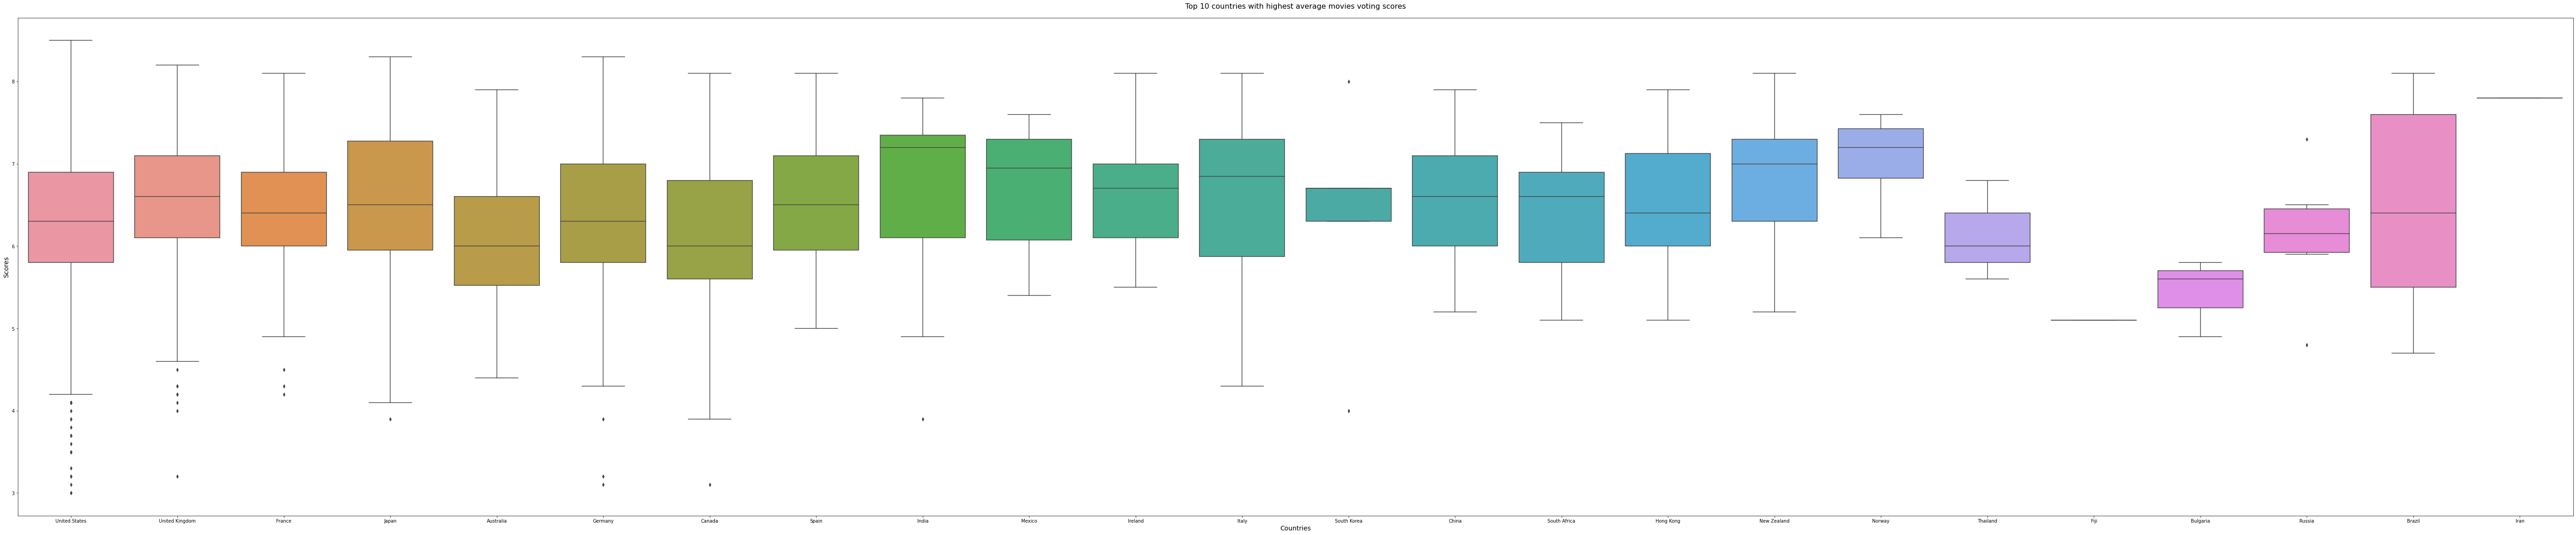

In [153]:
plt.figure(figsize=(100,20))
sns.boxplot(x='countries',y='score', data=countries_df)
plt.xlabel(xlabel="Countries",fontsize=14)
plt.ylabel(ylabel="Scores",fontsize=14)
plt.title('Top 10 countries with highest average movies voting scores',fontsize=16,pad=20)
plt.show()


In [154]:
countries_data = [list(i) for i in zip(new_countries['countries'],new_countries['num'])]

print(countries_data)

Map(init_opts=opts.InitOpts(width="1200px", height="1200px")).add("Movies",data_pair=countries_data ,maptype="world").set_series_opts(label_opts=opts.LabelOpts(is_show=False)).set_global_opts(
    title_opts=opts.TitleOpts(title=" d"),  
    visualmap_opts=opts.VisualMapOpts(
        max_ = 99999,
        is_piecewise=True,
        pieces =[{"max": 5, "min": 0, "label": "0-5",} ,
        {"max": 10, "min": 6, "label": "6-10",},
        {"max": 10, "min": 30, "label": "10-30",},
        {"max": 100, "min": 31, "label": "31-100",},
        {"max": 1000, "min": 101, "label": "101-1000",},
        {"max": 9999, "min": 1001, "label": "> 1000",}] 
    )
).render("Map.html")

[['United States', 1957], ['United Kingdom', 65], ['France', 18], ['Japan', 11], ['Australia', 8], ['Germany', 7], ['Canada', 7], ['Spain', 6], ['India', 5], ['Mexico', 3], ['Ireland', 3], ['Italy', 3], ['South Korea', 3], ['China', 3], ['South Africa', 2], ['Hong Kong', 2], ['New Zealand', 2], ['Norway', 2], ['Thailand', 1], ['Fiji', 1], ['Bulgaria', 1], ['Russia', 1], ['Brazil', 1], ['Iran', 1]]


'd:\\UK_Warwick_University\\Course\\CS910_Data Analytics\\Project\\movie\\Map.html'

### Companies

In [209]:
companies_ = set()
for i in new_df['production_companies'].str.split(','):
    companies_ = set().union(i,companies_)
companies_=list(companies_)

In [210]:
index = 0
for i in new_df['production_companies']:
    v = i.split(',')[0]
    new_df.loc[index,'companies'] = v 
    index+=1

new_companies =pd.DataFrame()
new_companies['companies'] = new_df['companies'].value_counts().index
new_companies['num'] = new_df['companies'].value_counts().values

new_companies

,companies,num
0,Paramount Pictures,225
1,Universal Pictures,219
2,Columbia Pictures,163
3,Twentieth Century Fox Film Corporation,149
4,New Line Cinema,129
...,...,...
653,Universal Pictures Corporation,1
654,Australian Film Finance Corporation,1
655,Autonomous,1
656,Boll Kino Beteiligungs GmbH & Co. KG,1


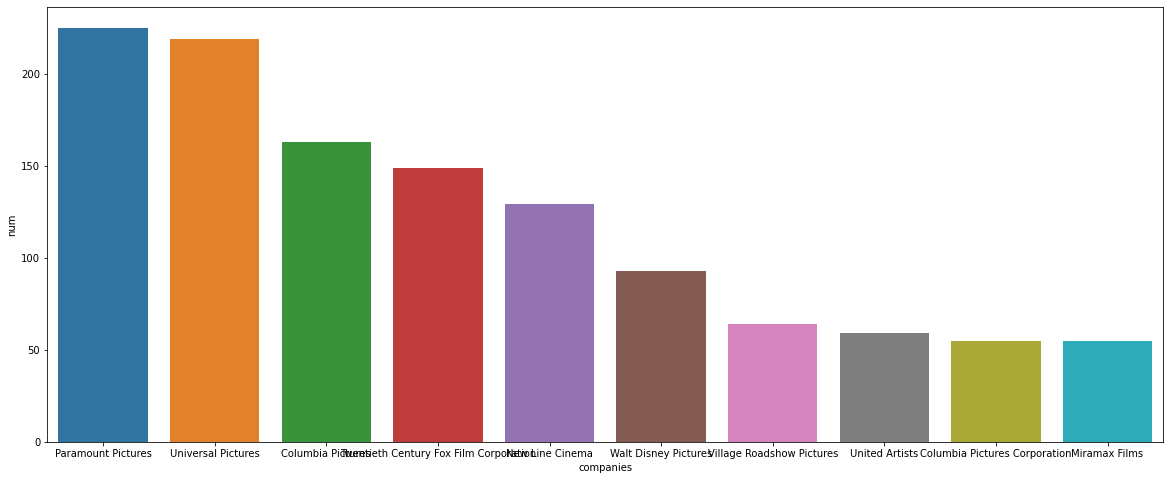

In [216]:
plt.figure(figsize=(25,8))
sns.barplot(x='companies', y='num', data=new_companies[:10])
plt.show()

In [227]:
companies_df = pd.DataFrame(columns=companies_)
for i in new_companies['companies']:
    list_=[]
    for j,t in zip(new_df["production_companies"],new_df["vote_average"]):
        if i in j:
            list_.append(t)
    companies_df[i]=pd.Series(list_)
companies_vote = companies_df.describe().T
companies_vote


,count,mean,std,min,25%,50%,75%,max
,229.0,6.425328,0.748721,4.2,5.90,6.4,7.000,8.2
Beverly Detroit,3.0,7.033333,1.123981,5.8,6.55,7.3,7.650,8.0
Max TV,1.0,6.800000,NaN,6.8,6.80,6.8,6.800,6.8
Katalyst Films,3.0,6.366667,0.832666,5.7,5.90,6.1,6.700,7.3
Euforia Film,1.0,6.100000,NaN,6.1,6.10,6.1,6.100,6.1
...,...,...,...,...,...,...,...,...
Kathbur Pictures,1.0,6.600000,NaN,6.6,6.60,6.6,6.600,6.6
Sony Pictures Animation,11.0,6.136364,0.463191,5.5,5.75,6.2,6.450,6.8
Craven-Maddalena Films,4.0,5.775000,0.499166,5.1,5.55,5.9,6.125,6.2
EM Media,3.0,7.233333,0.288675,6.9,7.15,7.4,7.400,7.4


In [228]:
companies_df = companies_df.T.stack().reset_index(level=1
                            ,drop=True
                            ,inplace= False
                            ).reset_index().rename(columns={"index":"companies",0:"score"})

companies_df["companies"].value_counts().sort_index()


                           229
100 Bares                    2
1492 Pictures               14
1818                         1
21 Laps Entertainment       12
                          ... 
Yash Raj Films               1
Younggu-Art Movies           1
Zentropa Entertainments      4
Zininsa Film Production      1
area japan                   1
Name: companies, Length: 658, dtype: int64

In [229]:
companies_df = companies_df[companies_df['companies'] != ''].reset_index(drop=True)
companies_df

,companies,score
0,Beverly Detroit,8.0
1,Beverly Detroit,5.8
2,Beverly Detroit,7.3
3,Max TV,6.8
4,Katalyst Films,5.7
...,...,...
6695,EM Media,6.9
6696,EM Media,7.4
6697,Black Bear Pictures,5.7
6698,Black Bear Pictures,8.0


### Language

In [221]:
language_df = new_df[(new_df['original_language'].isin((new_df['original_language'].value_counts()[:10].index.values)))]

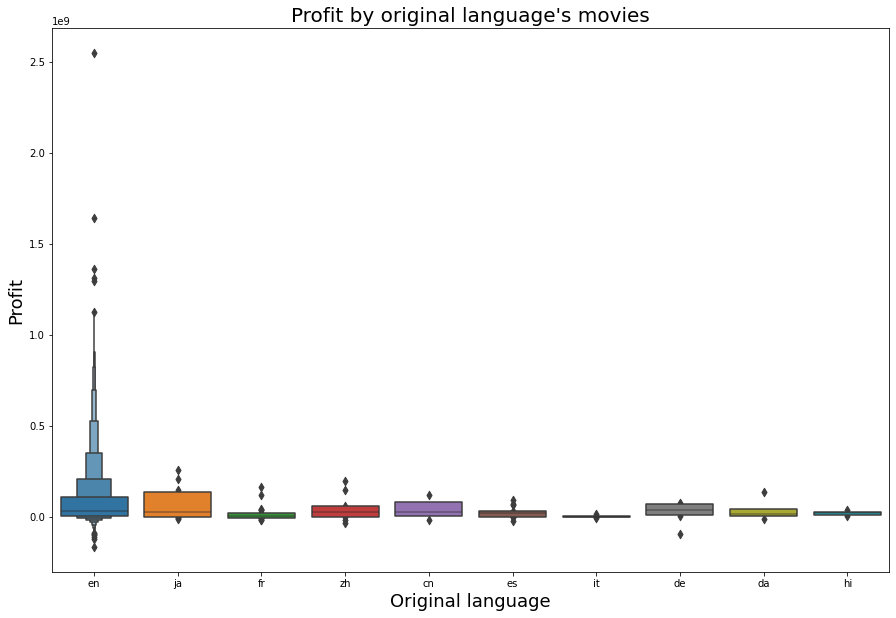

In [225]:
plt.figure(figsize=(15,10))

sns.boxenplot(x='original_language', y='profit',
                   data=language_df)
plt.title("Profit by original language's movies", fontsize=20)  
plt.xlabel('Original language', fontsize=18) 
plt.ylabel('Profit', fontsize=18) 
plt.show()

### Cast & Directors  

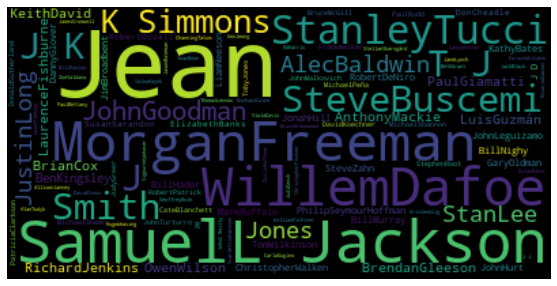

In [160]:
cast = ''.join(i for i in new_df['cast'].str.replace(' ',''))
worldcloud =WordCloud(background_color='black',stopwords=',').generate(cast)
plt.figure(figsize=(10,5))
plt.imshow(worldcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

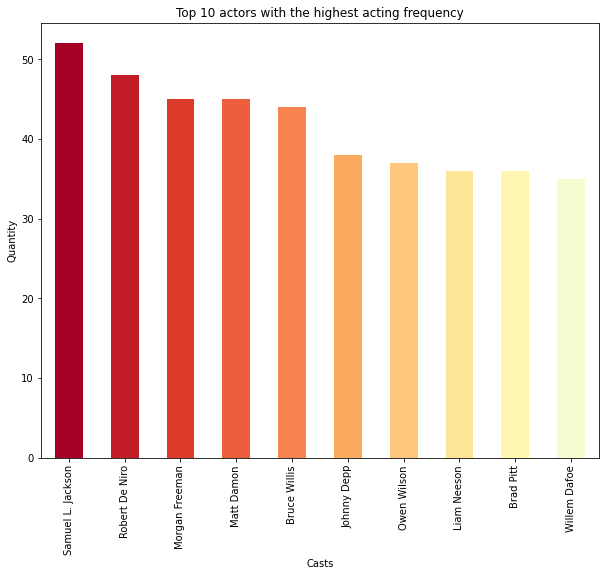

In [161]:
cast_data = new_df['cast'].str.split(',')
list_ = []
for i in cast_data:
    list_.extend(i)
cast = pd.Series(list_).value_counts()[:20].sort_values(ascending=False).drop({' Jr.'})

plt.figure(figsize=(10,8))
cast[:10].plot(kind ='bar',color=colors)
plt.title('Top 10 actors with the highest acting frequency')
plt.xlabel('Casts')
plt.ylabel('Quantity')
plt.show()


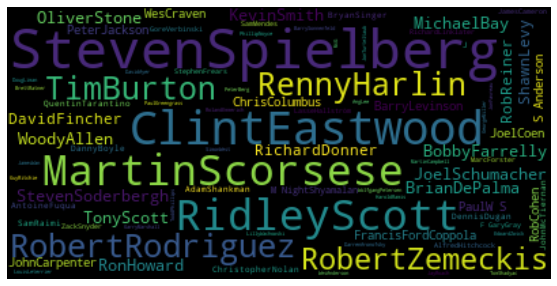

In [162]:
director = ''
for i in new_df['director'].str.replace(' ',''):
    director +=i
    director +=' ' 

worldcloud =WordCloud(background_color='black',stopwords=',').generate(director)
plt.figure(figsize=(10,5))
plt.imshow(worldcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

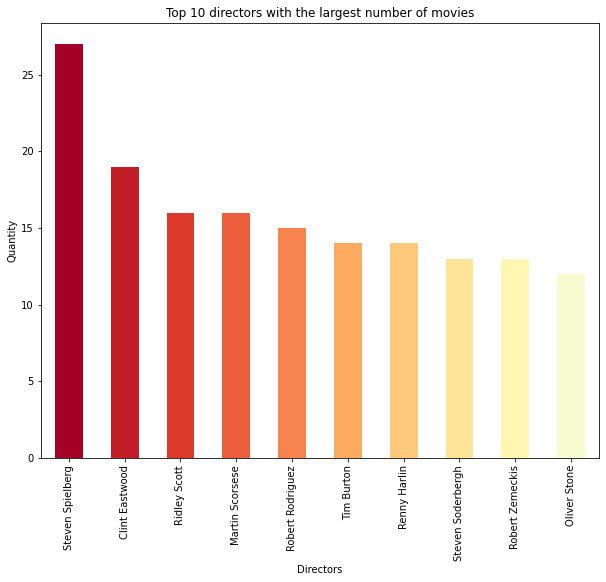

In [163]:
director_data = new_df['director'].value_counts()[:10].sort_values(ascending=False)

plt.figure(figsize=(10,8))
director_data.plot(kind ='bar',color=colors)
plt.title('Top 10 directors with the largest number of movies')
plt.xlabel('Directors')
plt.ylabel('Quantity')
plt.show()

### Keywords

WordCloud diagram

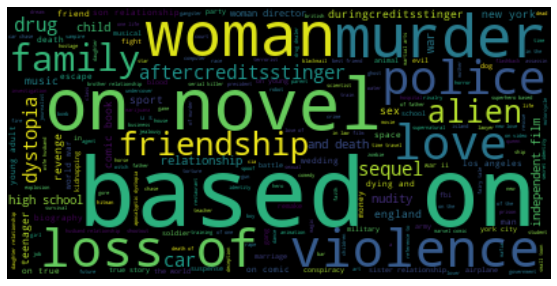

In [164]:
keywords = ''.join(i for i in new_df['keywords'])
worldcloud =WordCloud(background_color='black',stopwords=',').generate(keywords)
plt.figure(figsize=(10,5))
plt.imshow(worldcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Revenue & Profit

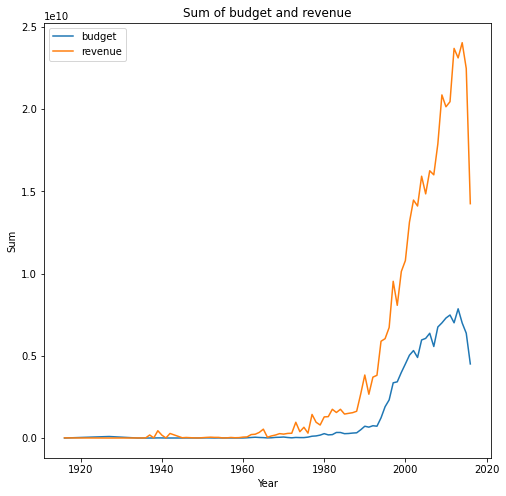

In [165]:
plt.figure(figsize=(8, 8))
x = new_df['release_year'].value_counts().sort_index(inplace=False).index
y1 = new_df.groupby('release_year').budget.sum()
y2 = new_df.groupby('release_year').revenue.sum()
plt.plot(x, y1, label = 'budget')
plt.plot(x, y2, label = 'revenue')
plt.xlabel('Year'); plt.ylabel('Sum'); plt.title('Sum of budget and revenue')
plt.legend()
plt.show()

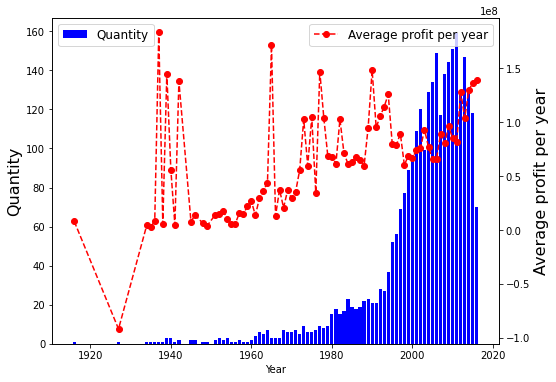

In [166]:
fig = plt.figure(figsize=(8,6))

x = new_df['release_year'].value_counts().sort_index(inplace=False).index
y1 = new_df.groupby('release_year').profit.size()
y2 = new_df.groupby('release_year').profit.mean() # 

# 
ax1 = fig.add_subplot(1,1,1)
plt.bar(x,y1,color='b',label='Quantity')
plt.grid(False)
ax1.set_xlabel('Year')                   
ax1.set_ylabel('Quantity',fontsize=16)
ax1.legend(loc=2,fontsize=12)

#
ax2 = ax1.twinx()
plt.plot(x,y2,'ro--',label='Average profit per year')
ax2.set_ylabel('Average profit per year',fontsize=16)
ax2.legend(loc=1,fontsize=12)

plt.show()


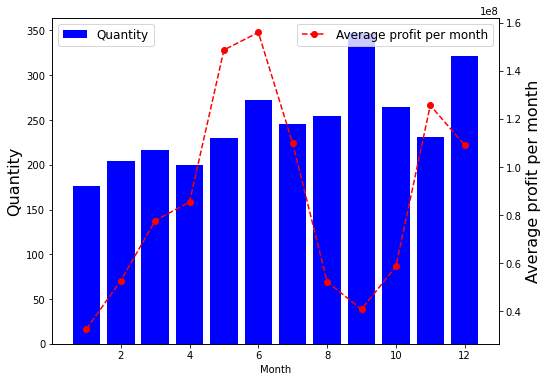

In [167]:
fig = plt.figure(figsize=(8,6))

x = new_df['release_month'].value_counts().sort_index(inplace=False).index
y1 = new_df.groupby('release_month').profit.size()
y2 = new_df.groupby('release_month').profit.mean()  

# 
ax1 = fig.add_subplot(1,1,1)
plt.bar(x,y1,color='b',label='Quantity')
plt.grid(False)
ax1.set_xlabel('Month')                   
ax1.set_ylabel('Quantity',fontsize=16)
ax1.legend(loc=2,fontsize=12)

#
ax2 = ax1.twinx()
plt.plot(x,y2,'ro--',label='Average profit per month')
ax2.set_ylabel('Average profit per month',fontsize=16)
ax2.legend(loc=1,fontsize=12)

plt.show()

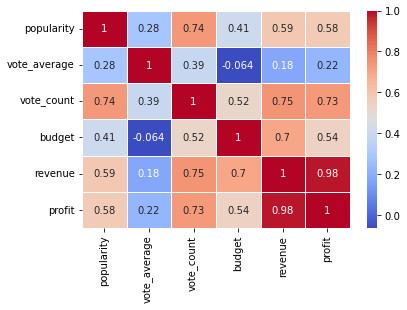

In [168]:
corr_df = new_df[['runtime', 'popularity', 'vote_average','vote_count','budget', 'revenue','profit']].corr()

sns.heatmap(
    corr_df,
    annot=True, 
    # cmap="Blues", 
    # cmap="YlGnBu", 
    cmap="coolwarm", 
    cbar=True, 
    linewidths=0.5, 
)
plt.show()

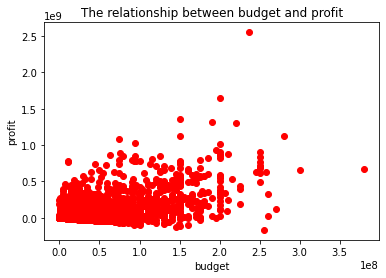

In [169]:
# plt.figure(figsize=(10, 10))
x = new_df.loc[:,'budget']
y = new_df.loc[:,'profit'] 
plt.scatter(x,y,color='r')
plt.title('The relationship between budget and profit')
plt.xlabel('budget')
plt.ylabel('profit')
plt.show()

In [170]:
new_df.to_csv('./movie.csv',quoting=1,index=False)